# Identifying Top Players and Significant Player Attributes Based on Player Position for European Football

**PROBLEM:**
The client, a European Football Club wants a model to predict the aggregated overall rating of a player at each age of the player. They want to identify the current top players for each playing position and the significant attributes that affect the player rating for each position. They will use this list of best players to consider during transfer season. In case they need to make a transfer, they will bring in a replacement, a major part of player selection depends upon which position the player will play at. Depending on the need of the team, the managers will consider the up and coming players who will suit their need. Our goal is to fit a model that predicts the overall rating using only the player attributes available to us in the data source.

**Data Source**: The data we will use for this problem is sourced from several websites such as 

http://football-data.mx-api.enetscores.com/: scores, lineup, team formation and events

http://www.football-data.co.uk/: betting odds

http://sofifa.com/:  players and teams attributes from EA Sports FIFA games, FIFA series and all FIFA assets property of EA Sports;

It is curated by Hugomathien and made available on Kaggle
Link: https://www.kaggle.com/hugomathien/soccer


We want to identify top players playing at each of the four positions - Forward, Defender, Midfielder and Goalkeeper from the dataset of players playing for different clubs in European Football since 2008 up to 2016. From the player attributes data we get a set of attributes such as overall_rating (also referred to as player rating), finishing, balance, diving etc. for the players. From the players table, we get the players age, weight and height. We know that *there is a relationship between the overall rating of a player and the player attributes, the player age, height and weight* so we use these attributes to build a model to predict the overall rating of a player. Using this model, given the attributes for a player we can project overall rating for the player at a future age

**Data Wrangling**: We will prepare the data for modeling, data is available in separate tables such as players (player id, birthday, weight), player_attributes (finishing, diving, balance etc.) and matches (player coordinates for a match played). We join these tables to get a dataset with all required player details, attributes and favored playing position. For each player we then aggregate data for each age of the player such that we have average overall rating, average finishing, etc. for each age. This is the final dataset for analysis and model building, to fit a regression model to predict the overall rating we analyze the data to test assumptions and identify patterns. 

## **Importing the packages**

In [1]:
#import packages
import os
import math
import pandas as pd
import numpy as np
import sqlite3
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import scipy
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn


# Import regression modules
# ols - stands for Ordinary least squares, we'll use this
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
lm = LinearRegression()


#import graph plotly modules
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

from sklearn import preprocessing
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set(style = "whitegrid", color_codes = True)
np.random.seed(sum(map(ord, "palettes")))

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_context("poster")

from sklearn import metrics

from statsmodels.stats.multicomp import pairwise_tukeyhsd


#formatting for table displays
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

 **Data Acquisition and Cleaning**

Data is available in sqlite database, below is a snapshot of each tables details:

1. Match : Match data with each row having -  match_date, home_team, opponent_team, player_ids of players playing in the match, player_id at each playing coordinate
2. Player: Player details- player_id, player_name, birthdate, height, weight
3. Player_Attributes: Attributes sourced from several sources for each match player has played - player_id, preferred_foot, attacking_work_rate, overall_rating, crossing, finishing, heading_accuracy, short_passing etc.
4. Country: country_id, country_name
5. League: id, country_id, league_name

Data is collected from this database and processed in order to merge some of these files to get player positions data and player league and country data in a more accesible format. It is not necessary that a player plays at the same position for each match, so we choose the players favoured position using the mode function to calculate the player position. These new tables are then pushed back into the database and this new sqlite database is used as source for this analyis. [Here]() is the link to the ipynb which contains the data manipulations code in detail.

**Data Source **

In [7]:
#connect to sqlite database and read files
countries = ""
matches = ""
leagues = ""
teams = ""

with sqlite3.connect('/Users/ruhama.ahale/Documents/git_repository/capstone-project big files/database_with_player_positions_and_league.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    players = pd.read_sql_query("SELECT * from Player", con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", con)
    player_positions = pd.read_sql_query("SELECT * from Player_Positions", con)
    players_with_league = pd.read_sql_query("SELECT * from Players_with_League_Country", con)

#len(players_with_league)

We merge the positions data with the attributes data and players data to get all details required for the players in a single data frame.

In [8]:
def lessPlayerPositionForPrefferedPositions(preferred_x_position, preferred_y_position):
    if (preferred_y_position == 1):
        return 'Goalkeeper'
    if (preferred_y_position > 1 and preferred_y_position <= 3):
        return 'Defender'
    if (preferred_y_position > 3 and preferred_y_position <= 8):
        return 'Midfielder'
    if (preferred_y_position > 8):
        return 'Forward'
    return 'Position Unknown'

for index, player in player_positions.iterrows():
    preferred_x_position = player['preferred_x_position']
    preferred_y_position = player['preferred_y_position']
    player_position = lessPlayerPositionForPrefferedPositions(preferred_x_position, preferred_y_position)
    player_positions.set_value(index, 'player_position', player_position)
    
#player_positions.head()

In [9]:
#merge all player files to get the player details required
player_positions = player_positions[['player_api_id', 'player_name', 'player_position']]
players_final_df = player_attributes
players_final_df = player_positions.merge(players_final_df,on='player_api_id')
player = players[['player_api_id', 'birthday', 'height', 'weight']]
players_final_df = players_final_df.merge(player,on='player_api_id')
players_final_df['birthday_date'] = pd.to_datetime(players_final_df['birthday'])
players_final_df['date'] = pd.to_datetime(players_final_df['date'])
players_final_df['age'] = players_final_df['date'] - players_final_df['birthday_date']
players_final_df['age'] = players_final_df['age'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
players_final_df['age'] = round(players_final_df['age']/365,0)
players_final_df = players_final_df[players_final_df.date >= '2009-07-31']#taking data only from 09-10 season onwards as data prior to that is not consistent
#rearrange the columns to keep feature sets together
players_final_df = players_final_df[['player_api_id',  'player_name',  'player_position',   'date',  'birthday_date', 'overall_rating',  'age', 'height',  'weight','finishing',  'heading_accuracy',  'short_passing',  'volleys',  'dribbling',  'curve',  'free_kick_accuracy',  'long_passing',  'ball_control',  'acceleration',  'sprint_speed',  'agility',  'reactions',  'balance',  'shot_power',  'jumping',  'stamina',  'strength',  'long_shots',  'aggression',  'interceptions',  'positioning',  'vision',  'penalties',  'marking',  'standing_tackle',  'sliding_tackle',  'gk_diving',  'gk_handling',  'gk_kicking',  'gk_positioning',  'gk_reflexes']]
#number of unique player in our new database
print('Total unique players in dataset: ', players_final_df.player_api_id.nunique())


Total unique players in dataset:  10867


Since data from 2008-09 season is inconsistent, we exclude that from our analysis

**Preparing the Data for Model Prediction and Data Analysis**

**Handling Missing Data:**

In [10]:
#Check proportion of missing values
players_final_df[players_final_df.columns[:]].isnull().sum()
players_final_df.isnull().any(axis=1).sum()
prop_missing = round((players_final_df[players_final_df.columns[:]].isnull().sum()/players_final_df[players_final_df.columns[:]].count())*100,4)
prop_missing

player_api_id         0.0000
player_name           0.0000
player_position       0.0000
date                  0.0000
birthday_date         0.0000
overall_rating        0.0611
age                   0.0000
height                0.0000
weight                0.0000
finishing             0.0611
heading_accuracy      0.0611
short_passing         0.0611
volleys               0.3578
dribbling             0.0611
curve                 0.3578
free_kick_accuracy    0.0611
long_passing          0.0611
ball_control          0.0611
acceleration          0.0611
sprint_speed          0.0611
agility               0.3578
reactions             0.0611
balance               0.3578
shot_power            0.0611
jumping               0.3578
stamina               0.0611
strength              0.0611
long_shots            0.0611
aggression            0.0611
interceptions         0.0611
positioning           0.0611
vision                0.3578
penalties             0.0611
marking               0.0611
standing_tackl

Since the proportion of missing values is very small, we ignore the missing values and delete them from the dataset.

In [11]:
players_final_df = players_final_df.dropna(axis=0, how='any')
players_final_df.isnull().any(axis=1).sum()
print('Unique players after removing missing data:', players_final_df.player_api_id.nunique())
print('Percent of players removed: ', ((1- (10582/10867))*100))

Unique players after removing missing data: 10582
Percent of players removed:  2.6226189380693876


As the proportion of players with any of the attributes data missing is less than 5% we proceed without these players

In [12]:
#count the unique players in each position
print('Unique players in each position:')
players_final_df.groupby(players_final_df.player_position).player_api_id.nunique()

Unique players in each position:


player_position
Defender      3536
Forward       2084
Goalkeeper     919
Midfielder    4043
Name: player_api_id, dtype: int64

##   **Data Analysis**

To get predicted ratings for players at the next age of player, we want data for ratings and attributes of a player at a given age. The data that we have has ratings and attributes at multiple matches for multiple ages of a player. So for one age of a player e.g. 25, there could be more than one match details. To get one data point for each age of a player we aggregate the features at that age using the average function - mean:

In [17]:
players_final_df = players_final_df.sort_values(['player_api_id', 'player_name', 'age'], ascending=[True, False, True])                                                                             
#For all players average the data for each age
players_agg = players_final_df.groupby([ 'player_api_id', 'player_name', 'player_position',  'age'],as_index=False, sort=False).mean()
players_agg = pd.DataFrame(players_agg)
players_agg = players_agg[[ 'player_api_id', 'player_name', 'player_position', 'overall_rating',  'age', 'height',  'weight', 'finishing',  'heading_accuracy',  'short_passing',  'volleys',  'dribbling',  'curve',  'free_kick_accuracy',  'long_passing',  'ball_control',  'acceleration',  'sprint_speed',  'agility',  'reactions',  'balance',  'shot_power',  'jumping',  'stamina',  'strength',  'long_shots',  'aggression',  'interceptions',  'positioning',  'vision',  'penalties',  'marking',  'standing_tackle',  'sliding_tackle',  'gk_diving',  'gk_handling',  'gk_kicking',  'gk_positioning',  'gk_reflexes']]
players_agg.describe()

,player_api_id,overall_rating,age,height,weight,finishing,heading_accuracy,short_passing,volleys,dribbling,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,...,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,52725.000000,52725.00000
mean,128807.768687,68.168710,26.070422,182.010980,169.056918,48.495372,56.690740,61.567312,48.034650,57.698582,...,56.951881,53.747098,46.596858,50.067561,47.642339,15.383802,16.553127,20.280548,16.633123,16.96874
std,130042.194779,6.719322,4.563284,6.401438,15.070259,19.201114,16.882404,14.386956,18.321289,18.092654,...,14.993739,15.827144,21.432128,21.639129,21.631294,17.726123,16.632624,20.595837,16.869654,17.99513
min,2625.000000,37.000000,16.000000,157.480000,117.000000,2.000000,3.000000,3.000000,1.000000,4.000000,...,1.000000,3.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000
25%,34225.000000,64.000000,23.000000,177.800000,159.000000,32.500000,49.000000,56.750000,34.000000,49.500000,...,48.000000,44.000000,25.000000,28.000000,25.000000,7.500000,8.000000,8.000000,8.000000,8.00000
50%,73841.000000,68.000000,26.000000,182.880000,168.000000,51.000000,60.000000,64.333333,51.000000,62.000000,...,59.000000,55.500000,51.000000,56.400000,53.000000,10.000000,12.000000,12.000000,12.000000,12.00000
75%,183532.000000,73.000000,29.000000,185.420000,179.000000,64.000000,68.000000,71.000000,62.600000,70.333333,...,68.000000,65.500000,66.000000,69.000000,66.400000,13.000000,15.000000,15.000000,15.000000,15.00000
max,750584.000000,94.000000,44.000000,208.280000,243.000000,97.000000,95.000000,97.000000,93.000000,97.000000,...,97.000000,96.000000,91.000000,94.500000,95.000000,93.000000,89.000000,96.000000,93.000000,94.00000


In [18]:
#sort the aggregate data for convinience
players_agg = players_agg.sort_values(['age'], ascending=True)

#subset into four positional dataframes
defender_df = players_agg[players_agg.player_position == 'Defender']
forward_df = players_agg[players_agg.player_position == 'Forward']
midfielder_df = players_agg[players_agg.player_position == 'Midfielder']
goalkeeper_df = players_agg[players_agg.player_position == 'Goalkeeper']

#We will use the above datasets for data modeling

In [19]:
print('Total unique players in players_agg: ', players_agg.player_api_id.nunique())
print('Total unique players in player_league_country: ', players_with_league.player_api_id.nunique())
print('Total unique players in player_positions: ', player_positions.player_api_id.nunique())
print('Total unique players missing in players_leagues: ', 
      ((players_agg.player_api_id.nunique() - players_with_league.player_api_id.nunique())/players_agg.player_api_id.nunique())*100)


Total unique players in players_agg:  10582
Total unique players in player_league_country:  7811
Total unique players in player_positions:  11060
Total unique players missing in players_leagues:  26.185976185976184


In [20]:
((10582-7811)/10582)*100

26.185976185976184

### ** 3.2 Data Exploration **

**3.2.1 Player Age Distribution**

Since the relationship of the player age and player rating is of interest to us, as there is a general assumption in football that player rating decreases with age of player, let us explore if this assumption is true for each of the playing positions

In [21]:
#subset for aggregates of only features by position and age
players_features_agg = players_final_df.groupby([ 'player_position', 'age'],as_index=False, sort=False).mean()
players_features_agg = pd.DataFrame(players_features_agg)
players_features_agg = players_features_agg.sort_values(['age'], ascending=True)
players_features_agg.head()


#subsets for features only aggregates
defender_df_agg = players_features_agg[players_features_agg.player_position == 'Defender']
forward_df_agg = players_features_agg[players_features_agg.player_position == 'Forward']
midfielder_df_agg = players_features_agg[players_features_agg.player_position == 'Midfielder']
goalkeeper_df_agg = players_features_agg[players_features_agg.player_position == 'Goalkeeper']



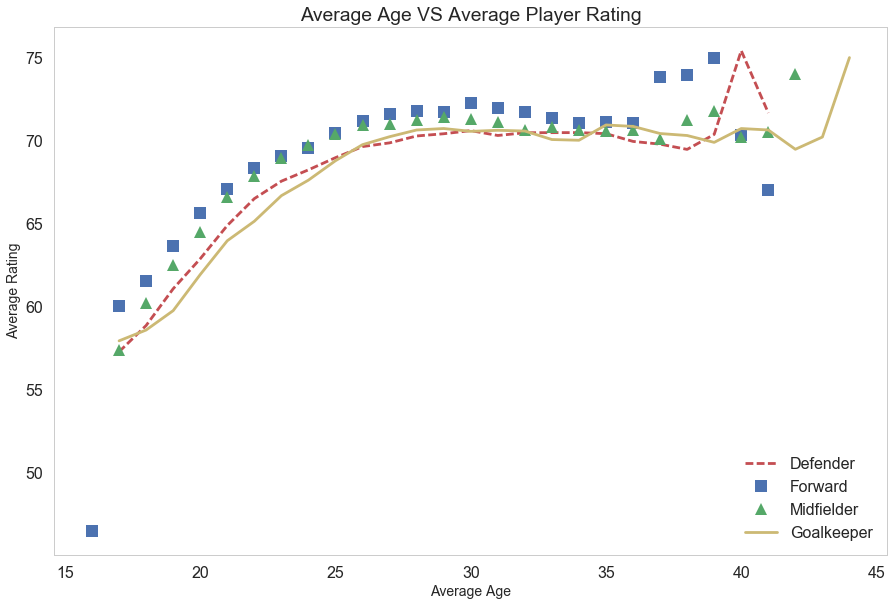

In [22]:
#plot average age vs Average rating by position
plt.plot(defender_df_agg.age, defender_df_agg.overall_rating, 'r--')
plt.plot(forward_df_agg.age, forward_df_agg.overall_rating, 'bs')
plt.plot(midfielder_df_agg.age, midfielder_df_agg.overall_rating, 'g^')
plt.plot(goalkeeper_df_agg.age, goalkeeper_df_agg.overall_rating, 'y-')
plt.legend(['Defender', 'Forward', 'Midfielder', 'Goalkeeper'], loc='lower right')
plt.grid(False)
plt.xlabel('Average Age', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Age VS Average Player Rating')
plt.tight_layout()
plt.show()

From the above plot, we can see that the player rating increases with age and for Defender, Midfielder and Forwards  around the age range of 30-35 the rating starts to drop. While for goalkeepers, the trend is different with ratings remaining high from ages 25 onwards. So the assumption that player rating falls as age increases is true only after age range of 30-33 years.


**3.2.3 Difference in Ratings Between Positions**

To predict the player rating we can separate  the data into train and test datasets and fit a regression model to the data to find a model with a good fit. However, we know that the data has 36 attributes for each player and according to our assumptions about the game, we think that there is a difference between ratings based on which position the player plays at. If this is true, it would make sense for us to separate the data by positions and fit separate models on each position data. For this purpose we test the following hypothesis:

H0: There is no significant difference between the mean ratings of the different position groups
                                        VS
H1: There is significant difference between the mean ratings of the different position groups

F_onewayResult(statistic=83.517342196633763, pvalue=6.6723804857405175e-54)

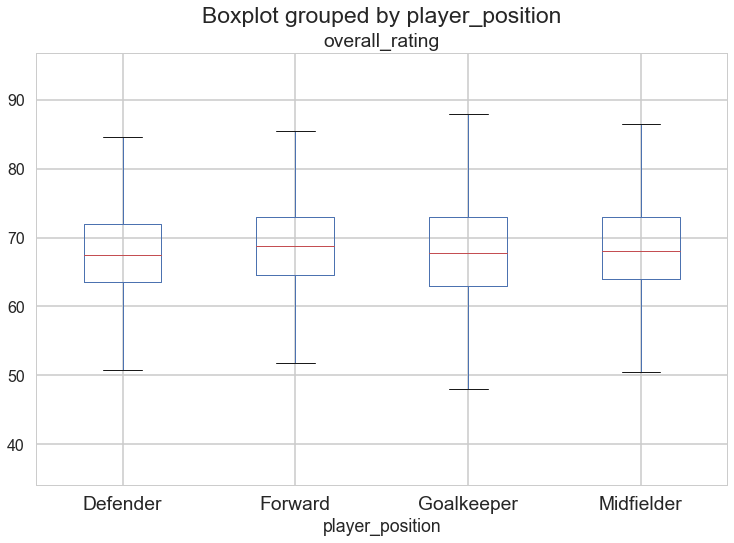

In [523]:
#subset the data for all positions
data = players_agg[['player_position', 'overall_rating']]
defn = data[data.player_position == 'Defender']
forwd = data[data.player_position == 'Forward']
midfld = data[data.player_position == 'Midfielder']
gkeep = data[data.player_position == 'Goalkeeper']
#Create a boxplot
data.boxplot('overall_rating', by='player_position', figsize=(12, 8))
stats.f_oneway(defn.overall_rating, forwd.overall_rating, midfld.overall_rating, gkeep.overall_rating)

The test result suggests the groups don't have the same sample means in this case, since the p-value is significant at a 95% confidence level. A common post hoc-test is Tukey's test, we carry out Tukey's test using the pairwise_tukeyhsd() function in the statsmodels.stats.multicomp library:

group1,group2,meandiff,lower,upper,reject
Defender,Forward,1.2678,1.0532,1.4825,True
Defender,Goalkeeper,0.2732,-0.0058,0.5523,False
Defender,Midfielder,0.6837,0.5058,0.8616,True
Forward,Goalkeeper,-0.9946,-1.2948,-0.6944,True
Forward,Midfielder,-0.5842,-0.7936,-0.3747,True
Goalkeeper,Midfielder,0.4104,0.1354,0.6855,True


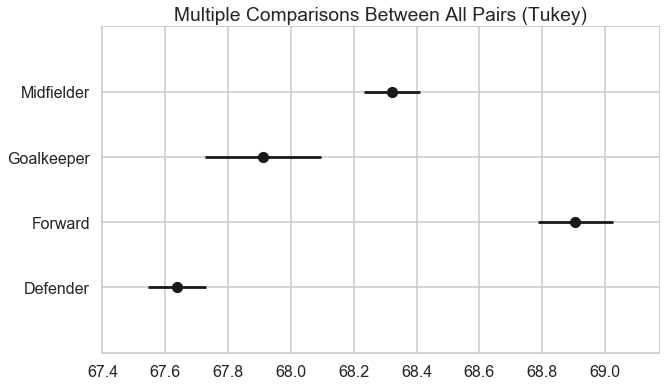

In [533]:
# post hoc analysis to identify difference between groups
tukey = pairwise_tukeyhsd(endog=data.overall_rating,     # Data
                          groups=data.player_position,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()      

The output of the Tukey test shows the average difference, a confidence interval as well as whether you should reject the null hypothesis for each pair of groups at the given significance level. In this case, the test suggests we reject the null hypothesis for 5 pairs, with an exception of the groups Defender-Goalkeeper. The 95% confidence interval plot reinforces the results visually: only Defender and Goalkeeper groups' confidence intervals overlap.

We have enough evidence to conclude that there is difference in ratings between the positional groups and we go forward with our suggestion to fit separate models for each position.